---
title: "High rate SEVIRI Level 1.5 Image Data MSG - Data Access"
subtitle: "This notebook demonstrates how to access SEVIRI data using HDA and how to read, process and visualize it."
author: "Author: Eumetsat"
tags: [HDA, SEVIRI]
thumbnail: ../../img/EUMETSAT-icon.png
license: MIT
copyright: "© 2024 EUMETSAT"
---

<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/EUM_data/DEDL-HDA-EO.EUM.DAT.MSG-1.5.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

The Spinning Enhanced Visible and InfraRed Imager (SEVIRI) is MSG’s primary instrument and has the capacity to observe the Earth in 12 spectral channels.

[Documentation DestinE Data Lake HDA](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.MSG.HRSEVIRI)
s
[High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree](https://navigator.eumetsat.int/product/EO:EUM:DAT:MSG:HRSEVIRI)

## Authenticate on DESP

In [10]:
import destinelab as deauth

In [11]:
import requests
import json
import os
import zipfile
import datetime
import shutil
from getpass import getpass

In [12]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


##  Search MSG data

In [13]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.EUM.DAT.MSG.HRSEVIRI"],
    "datetime": "2023-08-06T08:00:00Z/2023-08-07T00:00:00Z"
})


In [14]:
from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

### Download MSG

In [15]:
from tqdm import tqdm
import time

# Define a list of assets to download
#assets = ["Oa08_radiance.nc", "Oa06_radiance.nc", "Oa02_radiance.nc"]
assets = ["downloadLink"]

for asset in assets:
    download_url = product["assets"][asset]["href"]
    print(download_url)
    filename = asset
    print(filename)
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.MSG.HRSEVIRI/items/MSG3-SEVI-MSG15-0100-NA-20230806081241.839000000Z-NA/download?provider=eumetsat
downloadLink
downloading downloadLink


100%|██████████| 174M/174M [00:00<00:00, 600MB/s] 


In [16]:
zf=zipfile.ZipFile(filename)
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

## satpy

The Python package satpy supports reading and loading data from many input files. 
For MSG data and the Native format, we can use the satpy reader 'seviri_l1b_native.

In [17]:
pip install --quiet satpy

Note: you may need to restart the kernel to use updated packages.


Import required libraries

In [18]:
from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [19]:
file='MSG3-SEVI-MSG15-0100-NA-20230806081241.839000000Z-NA.nat'

### Read and load data

We use the Scene constructor from the satpy library, a Scene object represents a single geographic region of data.
Once loaded we can list all the available bands (spectral channel) for that scene.

In [20]:
# read the file
scn = Scene(reader='seviri_l1b_native', filenames=[file])
# print available datasets
scn.available_dataset_names()

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

With the function *load()*, you can specify an individual band by name. If you then select the loaded band, you see the xarray.DataArray band object 

In [21]:
# load bands 
scn.load(['HRV','IR_108'])
scn['IR_108']

<xarray.DataArray 'reshape-8f1cfe9b5a499c4823a77cddd1be9b1d' (y: 3712, x: 3712)>
dask.array<truediv, shape=(3712, 3712), dtype=float32, chunksize=(461, 3712), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT NaT ... NaT NaT NaT NaT NaT
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x         (x) float64 5.566e+06 5.563e+06 5.56e+06 ... -5.566e+06 -5.569e+06
Attributes: (12/18)
    orbital_parameters:       {'projection_longitude': 0.0, 'projection_latit...
    units:                    K
    wavelength:               10.8 µm (9.8-11.8 µm)
    standard_name:            toa_brightness_temperature
    platform_name:            Meteosat-10
    sensor:                   seviri
    ...                       ...
    name:                     IR_108
    resolution:               3000.403165817
    calibration:              brightness_temperature
    modifiers:                ()
    _satpy_id:                DataID(name='IR_108', wavelength=WavelengthRang...
    ancillary_variables:      []

In [22]:
scn['IR_108'].attrs.keys()

dict_keys(['orbital_parameters', 'units', 'wavelength', 'standard_name', 'platform_name', 'sensor', 'georef_offset_corrected', 'time_parameters', 'start_time', 'end_time', 'reader', 'area', 'name', 'resolution', 'calibration', 'modifiers', '_satpy_id', 'ancillary_variables'])

In [23]:
scn['IR_108'].attrs['wavelength']

WavelengthRange(min=9.8, central=10.8, max=11.8, unit='µm')

### Visualize data combining bands

The Satpy function *available_composite_ids()*  returns a list of available composite IDs. 

In [24]:
scn = Scene(reader="seviri_l1b_native", 
             filenames=[file])

In [25]:
scn.available_composite_ids()

[DataID(name='24h_microphysics'),
 DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='cloud_phase_distinction'),
 DataID(name='cloud_phase_distinction_raw'),
 DataID(name='cloudtop'),
 DataID(name='cloudtop_daytime'),
 DataID(name='colorized_ir_clouds'),
 DataID(name='convection'),
 DataID(name='day_microphysics'),
 DataID(name='day_microphysics_winter'),
 DataID(name='dust'),
 DataID(name='fog'),
 DataID(name='green_snow'),
 DataID(name='hrv_clouds'),
 DataID(name='hrv_fog'),
 DataID(name='hrv_severe_storms'),
 DataID(name='hrv_severe_storms_masked'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='ir_overview'),
 DataID(name='ir_sandwich'),
 DataID(name='natural_color'),
 DataID(name='natural_color_nocorr'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_color_raw_with_night_ir'),
 DataID(name='natural_color_with_night_ir'),
 DataID(name='natural_color_with_night_ir_hires'),
 DataID(name='natural_enh'),
 DataID(name='natural_enh_with_night_ir')

In [26]:
composite_id = ["natural_color"]
scn.load(composite_id, upper_right_corner="NE")


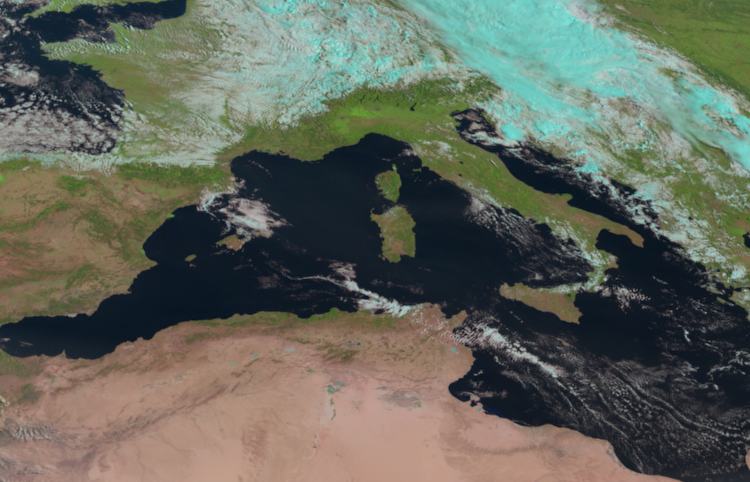

In [27]:
scn_cropped = scn.crop(ll_bbox=(-5, 31, 20, 51))
scn_cropped.show("natural_color")

In [30]:

composite_id = ["colorized_ir_clouds"]
scn.load(composite_id, upper_right_corner="NE")

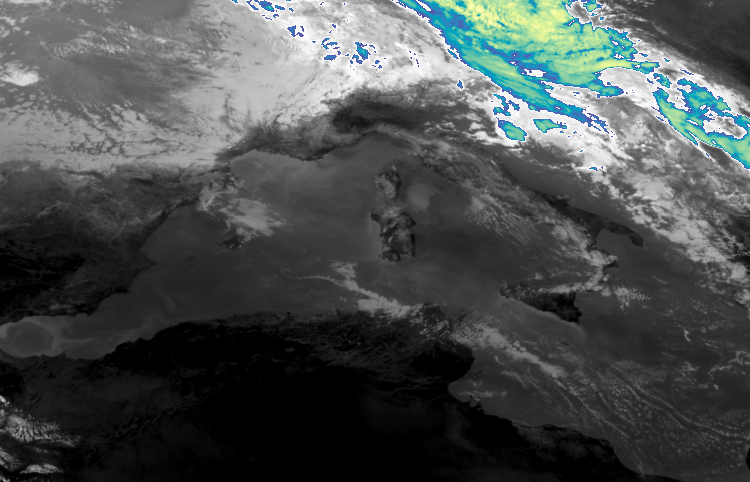

In [31]:
scn_cropped = scn.crop(ll_bbox=(-5, 31, 20, 51))
scn_cropped.show("colorized_ir_clouds")